In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import time
import joblib


In [4]:
# Function for memory analysis and DataFrame information
def analyze_memory(df):
    print("\n=== Memory Analysis and DataFrame Information ===")
    memory = df.memory_usage(deep=True).sum() / 1024 ** 2
    print(f"Total memory used by DataFrame: {memory:.2f} MB")
    print("\nDetailed DataFrame information:")
    print(df.info())
    print("\nMissing values per column:")
    print(df.isnull().sum())


In [5]:
# Loading the Dataset
df = pd.read_csv(r"creditcard.csv")

# Perform memory analysis and DataFrame information
analyze_memory(df)



=== Memory Analysis and DataFrame Information ===
Total memory used by DataFrame: 67.36 MB

Detailed DataFrame information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18 


Statistical description:
           count          mean           std         min           25%  \
Time    284807.0  9.481386e+04  47488.145955    0.000000  54201.500000   
V1      284807.0  1.168375e-15      1.958696  -56.407510     -0.920373   
V2      284807.0  3.416908e-16      1.651309  -72.715728     -0.598550   
V3      284807.0 -1.379537e-15      1.516255  -48.325589     -0.890365   
V4      284807.0  2.074095e-15      1.415869   -5.683171     -0.848640   
V5      284807.0  9.604066e-16      1.380247 -113.743307     -0.691597   
V6      284807.0  1.487313e-15      1.332271  -26.160506     -0.768296   
V7      284807.0 -5.556467e-16      1.237094  -43.557242     -0.554076   
V8      284807.0  1.213481e-16      1.194353  -73.216718     -0.208630   
V9      284807.0 -2.406331e-15      1.098632  -13.434066     -0.643098   
V10     284807.0  2.239053e-15      1.088850  -24.588262     -0.535426   
V11     284807.0  1.673327e-15      1.020713   -4.797473     -0.762494   
V12     2848

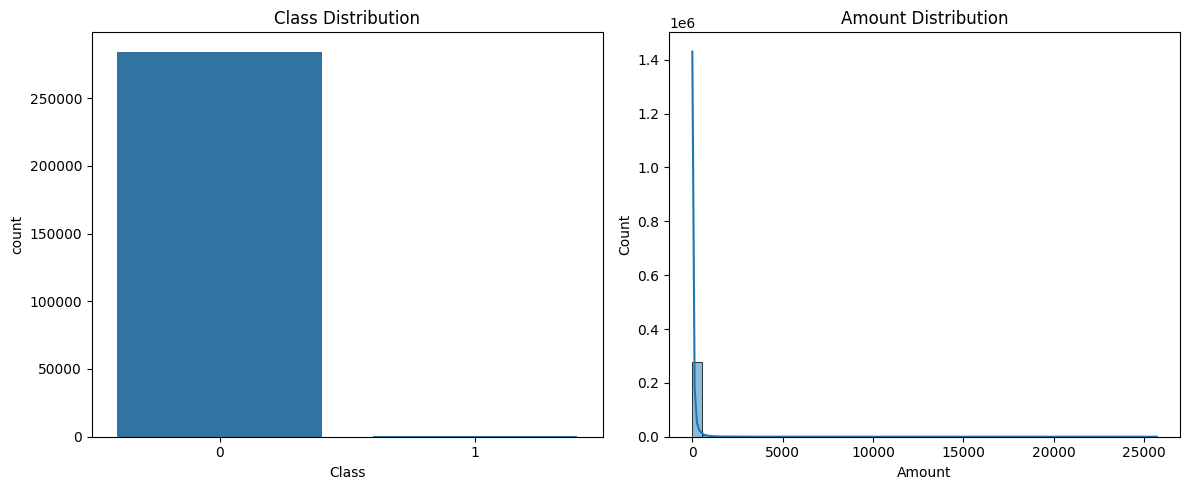

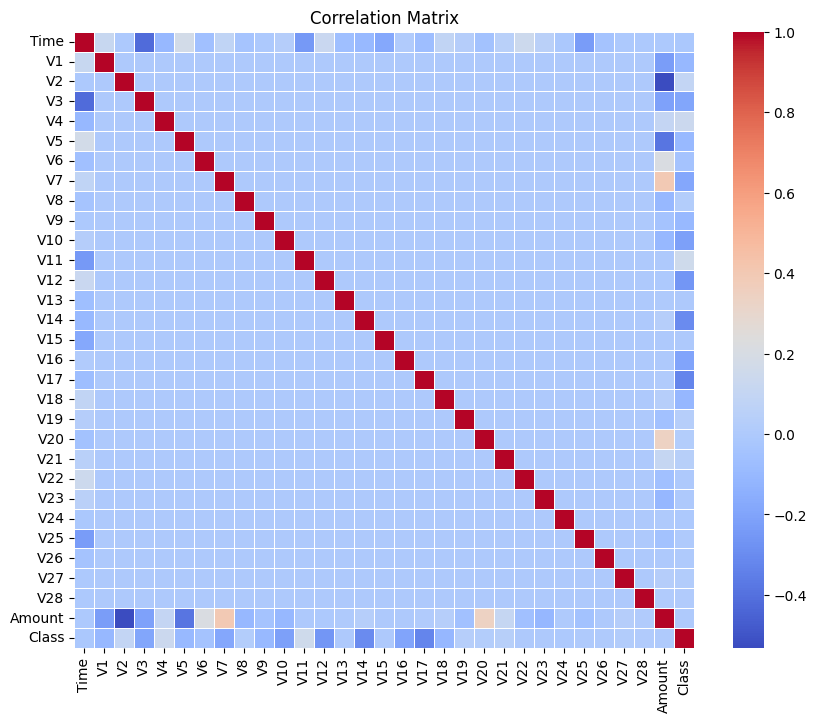

In [6]:
# Exploratory Data Analysis (EDA)
print("\nStatistical description:")
print(df.describe().T)

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Distribution of the target variable (Class)
sns.countplot(data=df, x='Class', ax=axes[0])
axes[0].set_title('Class Distribution')

# Analysis of the distribution of the Amount variable
sns.histplot(df['Amount'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Amount Distribution')

plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [8]:
# Separating independent and dependent variables
X = df.drop('Class', axis=1)
y = df['Class']

# Analysis of class imbalance
print("\nClass Distribution (Imbalanced):")
print(y.value_counts(normalize=True))

# Normalization of the Amount variable
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Applying SMOTE only to the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)



Class Distribution (Imbalanced):
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [9]:
# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    start = time.time()
    # Cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5)
    mean_scores = scores.mean()
    # Training
    model.fit(X_train, y_train)
    # Predictions and evaluation on the test set
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    # Calculation of AUC-ROC
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    execution_time = time.time() - start
    return {
        "scores": scores,
        "mean_scores": mean_scores,
        "report": report,
        "confusion_matrix": conf_matrix,
        "roc_auc": roc_auc,
        "execution_time": execution_time
    }

# Isolate XGBoost model evaluation
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_results = evaluate_model(xgb_model, X_train_res, y_train_res, X_test, y_test)

# Displaying the XGBoost results
print("\n=== XGBoost ===")
print("Cross-Validation Scores:", xgb_results['scores'])
print("Mean Scores:", xgb_results['mean_scores'])
print("Classification Report:\n", xgb_results['report'])
print("Confusion Matrix:\n", xgb_results['confusion_matrix'])
print("AUC-ROC:\n", xgb_results['roc_auc'])
print("Execution Time (s):\n", xgb_results['execution_time'])



=== XGBoost ===
Cross-Validation Scores: [0.99989951 0.99978645 0.99979902 0.99979902 0.99982414]
Mean Scores: 0.9998216259672394
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.85      0.82      0.83       148

    accuracy                           1.00     85443
   macro avg       0.93      0.91      0.92     85443
weighted avg       1.00      1.00      1.00     85443

Confusion Matrix:
 [[85274    21]
 [   27   121]]
AUC-ROC:
 0.9763857312380086
Execution Time (s):
 33.56413245201111
